# Tools and packages   

**Pyhton 3.10.13**   
**pandas v1.3.5**   
**numpy v1.21.5**   
**statistics**   
**scipy v1.7.3**   
**scikit-learn v.0.22.1**   
**statsmodels v.0.13.5**   
**matplotlib v3.5.3**   
**seaborn v0.12.2**   
**plotly v5.17.0**   
**biopython v1.78**    
   

# Resources and References
1. [NCBI](https://www.ncbi.nlm.nih.gov/)    
2. [cBioPortal](http://www.cbioportal.org/)   
3. Cancer Genome Atlas Network. Genomic Classification of Cutaneous Melanoma. Cell. 2015 Jun 18;161(7):1681-96. doi: 10.1016/j.cell.2015.05.044. PMID: 26091043; PMCID: [PMC4580370.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4580370/)    
4. Gene Expression Profiling–Based Identification of Molecular Subtypes in Stage IV Melanomas with Different Clinical Outcome. Clin Cancer Res (2010) 16 (13): 3356–3367. [doi:/10.1158/1078-0432.CCR-09-2509](https://aacrjournals.org/clincancerres/article/16/13/3356/11021/XSLT_Related_Article_Replace_Href)   
5. Piccolo SR, Mecham A, Golightly NP, Johnson JL, Miller DB. The ability to classify patients based on gene-expression data varies by algorithm and performance metric. PLoS Comput Biol. 2022 Mar 11;18(3):e1009926. doi: 10.1371/journal.pcbi.1009926. PMID: 35275931; [PMCID: PMC8942277.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8942277/)
   
     
# Imports


In [2]:
import pandas as pd
import numpy as np
import os

from scipy.stats import median_abs_deviation
from scipy.spatial.distance import pdist
from scipy.stats import mannwhitneyu
from scipy.cluster import hierarchy
from scipy.stats import pearsonr 
from scipy.spatial import distance
from statsmodels.stats.multitest import multipletests

from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay

import matplotlib.pyplot as plt
import plotly.graph_objs as go
import kaplanmeier as km


from Bio import Entrez
Entrez.email = "an.eudokimova@yandex.ru"

# Some technical functions and settings

In [28]:
# set working directory
# here there are all input data: clustering_329.xlsx - clustered 329 samples from the first article
# and folder skcm_tcga - full data on a cohort of melanoma patients
# all results will be saved here
os.chdir("D:\\BostonGene\\TEST\\")

# display pandas DF
pd.set_option("display.max_rows", 5)

# display long tables
def table(df, columnwidth, title_text):
    fig = go.Figure(data=[go.Table(
    columnwidth = columnwidth,
    header=dict(values=list(df.columns),
                align='left'),
    cells=dict(values=[df[i] for i in df.columns],           
                align='left'))
    ])
    fig.update_layout(
    height=800,
    showlegend=False,
    title_text=title_text)

    app = Dash()
    app.layout = html.Div([
        dcc.Graph(figure=fig)])
    app.run_server(debug=True, use_reloader=True)

In [29]:
table(group1_genes, [12, 8, 15, 90], 'Genes from group 1')

# Load and prepare data

In [113]:
# 329 described in the first article ans clustered samples
clustering_329 = pd.read_excel('clustering_329.xlsx')
clustering_329 = clustering_329.loc[clustering_329['RNASEQ-CLUSTER_CONSENHIER'] != '-'].reset_index().drop('index', axis=1)
clustering_329

,Name,RNASEQ-CLUSTER_CONSENHIER
0,TCGA-BF-A1PU-01,keratin
1,TCGA-BF-A1PV-01,keratin
...,...,...
327,TCGA-HR-A5NC-01,keratin
328,TCGA-IH-A3EA-01,keratin


In [114]:
# mRNA Seq upper quartile normalized RSEM, log2 -transformed and median centered across samples data
# all samples (472)
mrna_zcores = pd.read_csv('skcm_tcga\data_mrna_seq_v2_rsem_zscores_ref_all_samples.txt', sep='\t')
mrna_zcores

,Hugo_Symbol,Entrez_Gene_Id,TCGA-3N-A9WB-06,TCGA-3N-A9WC-06,TCGA-3N-A9WD-06,TCGA-BF-A1PU-01,TCGA-BF-A1PV-01,TCGA-BF-A1PX-01,TCGA-BF-A1PZ-01,TCGA-BF-A1Q0-01,...,TCGA-XV-AB01-06,TCGA-YD-A89C-06,TCGA-YD-A9TA-06,TCGA-YD-A9TB-06,TCGA-YG-AA3N-01,TCGA-YG-AA3O-06,TCGA-YG-AA3P-06,TCGA-Z2-A8RT-06,TCGA-Z2-AA3S-06,TCGA-Z2-AA3V-06
0,LOC100130426,100130426,-4.7294,-4.7294,-4.7294,-4.7294,-4.7294,-4.7294,-4.7294,-4.7294,...,-4.7294,-4.7294,-4.7294,-4.7294,1.6457,-4.7294,-4.7294,-4.7294,-4.7294,-4.7294
1,UBE2Q2P3,100133144,-0.0298,0.1445,0.1639,-1.8924,-0.3805,-1.6986,-1.1376,1.9075,...,-2.2617,1.6347,2.6880,0.1601,-1.6843,1.7471,-1.5872,0.7220,-0.3672,-0.5248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20529,TPTEP1,387590,-0.9070,-0.5454,2.5005,-0.9604,-1.1788,2.9394,-1.5040,-0.4323,...,0.5895,-1.5267,-0.6127,-0.4737,0.5577,-0.7263,0.0930,-0.4595,-0.8333,0.9540
20530,AKR1C6P,389932,-2.8387,-0.4852,-2.8387,-2.8387,-2.8387,-2.8387,-2.8387,-2.8387,...,-2.8387,-2.8387,-0.8132,-2.8387,-2.8387,-2.8387,-2.8387,-2.8387,-1.0741,-2.8387


In [115]:
# information about patients
data_clinical_patient = pd.read_csv('skcm_tcga\data_clinical_patient.txt', sep='\t', comment='#')
data_clinical_patient

,OTHER_PATIENT_ID,PATIENT_ID,FORM_COMPLETION_DATE,PROSPECTIVE_COLLECTION,RETROSPECTIVE_COLLECTION,SEX,HEIGHT,WEIGHT,RACE,ETHNICITY,...,ICD_O_3_SITE,INFORMED_CONSENT_VERIFIED,PROJECT_CODE,STAGE_OTHER,TISSUE_SOURCE_SITE,TUMOR_TISSUE_SITE_OTHER,OS_STATUS,OS_MONTHS,DFS_STATUS,DFS_MONTHS
0,5564E6A7-2195-4B0D-994E-B0617B58E889,TCGA-3N-A9WB,5/29/14,YES,NO,Male,175,78,WHITE,NOT HISPANIC OR LATINO,...,C44.5,YES,[Not Available],[Not Available],3N,[Not Applicable],1:DECEASED,17.02,1:Recurred/Progressed,16
1,551E071A-C290-4B48-9000-F64C2A44DFB7,TCGA-3N-A9WC,5/29/14,YES,NO,Male,183,68,WHITE,NOT HISPANIC OR LATINO,...,C77.3,YES,[Not Available],[Not Available],3N,[Not Applicable],0:LIVING,66.43,1:Recurred/Progressed,56.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,71B347AC-6AC6-475D-8E21-754764180948,TCGA-Z2-AA3S,6/30/14,YES,NO,Male,172,78,WHITE,NOT HISPANIC OR LATINO,...,C77.3,YES,[Not Available],[Not Available],Z2,[Not Applicable],0:LIVING,96.91,1:Recurred/Progressed,93.5
469,5B10234B-6189-449F-8886-D0D44A729CED,TCGA-Z2-AA3V,6/30/14,YES,NO,Female,166,63,WHITE,NOT HISPANIC OR LATINO,...,C77.3,YES,[Not Available],[Not Available],Z2,[Not Applicable],0:LIVING,15.97,0:DiseaseFree,15.97


# Task 1    
## Problem: 
there are [acticle](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4580370/) that describes the procedure of genomic classification patients with  cutaneous melanoma (329 samples). We have data on new patients and want to classify them too. So, we have two way to do it:   
- repeat the clustering procedure from the article again, but for all samples   
OR   
- use the classification of 329 samples to further classify new ones   
   
We try both of them   

## 1. Repeat prosedure from the article  (for 329 samples)     
Firstly, let's try to repeat clusterization from the article for 329 "old" samples amd compare results.   
We try to devide samples in three group (yes, to be honest, we should assume that we don't know about the number of groups, but it's much more complicagted problem).  
Algorithm from the acticle: 
1. mRNA Seq data   
2. RSEM normalization   
3. log2 -transformation and median centering across samples   
4. selection 1500 most variably expressed genes   
5. unsupervised clustering 

We download data from point 3, select 329 samples, and after that we can start with point 4   


In [116]:
# get mRNA Seq data for 329 samples
mrna_zcores_329 = pd.concat([mrna_zcores[['Hugo_Symbol', 'Entrez_Gene_Id']], mrna_zcores[clustering_329['Name']]], axis=1)
mrna_zcores_329 = mrna_zcores_329.dropna()
mrna_zcores_329

,Hugo_Symbol,Entrez_Gene_Id,TCGA-BF-A1PU-01,TCGA-BF-A1PV-01,TCGA-BF-A1PX-01,TCGA-BF-A1PZ-01,TCGA-BF-A1Q0-01,TCGA-BF-A3DJ-01,TCGA-BF-A3DL-01,TCGA-BF-A3DM-01,...,TCGA-GN-A264-06,TCGA-GN-A265-06,TCGA-GN-A266-06,TCGA-GN-A267-06,TCGA-GN-A268-06,TCGA-GN-A26A-06,TCGA-GN-A26C-01,TCGA-GN-A26D-06,TCGA-HR-A5NC-01,TCGA-IH-A3EA-01
0,LOC100130426,100130426,-4.7294,-4.7294,-4.7294,-4.7294,-4.7294,-4.7294,-4.7294,-4.7294,...,-4.7294,-4.7294,-4.7294,-4.7294,-4.7294,-4.7294,-4.7294,-4.7294,-4.7294,-4.7294
1,UBE2Q2P3,100133144,-1.8924,-0.3805,-1.6986,-1.1376,1.9075,-0.5837,-1.5987,0.0552,...,-0.9677,0.5279,-0.2342,-0.7011,1.3701,-2.2617,1.1338,-0.2261,-0.8385,-2.2617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20529,TPTEP1,387590,-0.9604,-1.1788,2.9394,-1.5040,-0.4323,-0.5443,-0.2333,-0.8261,...,0.1604,0.9208,0.9611,-0.2901,-1.1494,0.7761,0.6521,-0.7002,2.7166,-1.1176
20530,AKR1C6P,389932,-2.8387,-2.8387,-2.8387,-2.8387,-2.8387,-0.7742,-2.8387,-2.8387,...,-2.8387,-2.8387,-2.8387,-2.8387,-2.8387,-2.8387,-2.8387,-2.8387,-2.8387,-2.8387


##### **1.1 Selection of 1500 significant genes**   
In the [acticle](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4580370/) they used 1500 the most variable expressed genes for clustering samples, but they didn't explain how they estimate "variabulity". But in a similar [analysis](http://dx.doi.org/10.7908/C1057FCR) the Median Absolute Deviation (MAD) was used. 

In [117]:
# select 1500 the most variable genes
def select_1500_genes(df):
    df['MAD'] = df.iloc[:, 2:df.shape[1]].apply(median_abs_deviation, axis=1)
    top_1500 = df.sort_values('MAD', ascending=False).iloc[0:1500, :]
    top_1500 = top_1500.drop(['Entrez_Gene_Id', 'MAD'], axis=1).set_index('Hugo_Symbol')
    return top_1500

top_1500 = select_1500_genes(mrna_zcores_329)
top_1500

,TCGA-BF-A1PU-01,TCGA-BF-A1PV-01,TCGA-BF-A1PX-01,TCGA-BF-A1PZ-01,TCGA-BF-A1Q0-01,TCGA-BF-A3DJ-01,TCGA-BF-A3DL-01,TCGA-BF-A3DM-01,TCGA-BF-A3DN-01,TCGA-BF-A5EO-01,...,TCGA-GN-A264-06,TCGA-GN-A265-06,TCGA-GN-A266-06,TCGA-GN-A267-06,TCGA-GN-A268-06,TCGA-GN-A26A-06,TCGA-GN-A26C-01,TCGA-GN-A26D-06,TCGA-HR-A5NC-01,TCGA-IH-A3EA-01
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,,
TMEM189-UBE2V1,1.3173,-1.1315,-3.8273,-1.0419,3.5824,-3.8273,0.9266,1.0069,-1.1662,-3.8273,...,-0.1300,-3.8273,0.6313,-3.8273,0.5274,-3.8273,-3.8273,-1.2957,-0.1123,-3.8273
CYorf15B,-2.2316,-2.2316,0.5641,-2.2316,0.2353,-2.2316,-2.2316,0.8000,-2.0918,-0.1006,...,0.8520,0.1948,0.0032,-0.6154,-2.2316,-2.2316,0.5281,-2.2316,-2.2316,-1.6287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SERTAD4,0.9918,0.6826,1.1860,-0.3027,1.2003,1.3933,0.0014,0.9925,0.5965,-1.4305,...,-0.4893,-0.4973,0.4091,-0.8835,1.5168,1.0256,-1.3169,-1.1854,0.2210,0.2243
GIMAP4,-1.0059,-1.4986,0.9852,-0.6835,-0.1154,0.1517,-1.0182,-1.2416,-0.4093,-1.0362,...,-0.8567,1.3865,1.1625,0.3741,-1.1848,0.3797,1.3509,-1.1681,-0.6921,-1.4946


##### **1.2 Hierarchical clustering**    
In the [acticle](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4580370/) consensus ```average``` linkage hierarchical clustering was used, but our dendrogram is awful with this parameter. We try ```ward``` linkage hierarchical clustering, which was used in the forementioned [analysis](http://dx.doi.org/10.7908/C1057FCR)     
In the dendrogram below we can see, that our samples could be divided into three groups:

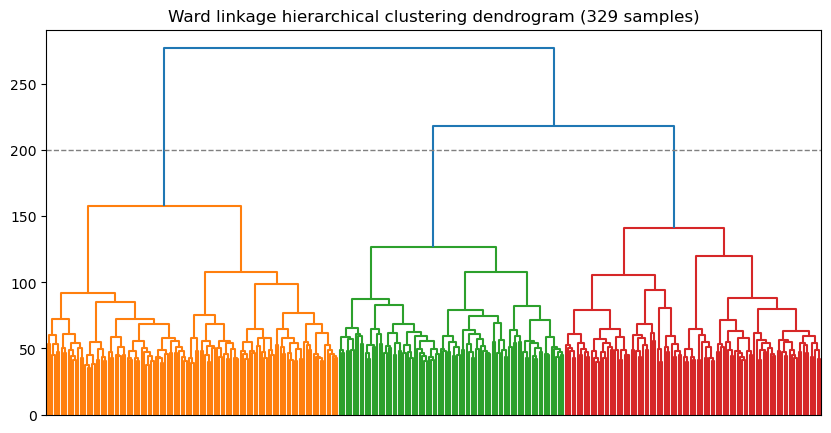

In [118]:
# plot dendrogram
def plot_dendrogram(df, color_threshold=200, title='Ward linkage hierarchical clustering dendrogram'):
    X = np.array(df.T)
    distance_mat = pdist(X)
    Z = hierarchy.linkage(distance_mat, 'ward') 
    plt.figure(figsize=(10, 5))
    hierarchy.dendrogram(Z, color_threshold=color_threshold, no_labels=True)
    plt.axhline(y=color_threshold, c='grey', lw=1, linestyle='dashed')
    plt.title(title)

plot_dendrogram(top_1500, title='Ward linkage hierarchical clustering dendrogram (329 samples)')

For hierarchical clustering we use Agglomerative Clustering algorithm:

In [119]:
X = np.array(top_1500.T)
clustering = AgglomerativeClustering(linkage='ward',
                                     n_clusters=3)
labels = list(clustering.fit(X).labels_)

# write results
cluster_top_1500 = top_1500.T
cluster_top_1500.insert(0, 'labels', labels)
# look at the numbers of samples in each cluster
labels.count(0), labels.count(1), labels.count(2)

(124, 109, 96)

##### **1.3 Сomparison of sample groups**     
Now we should find out, which genes distinguish groups of samples from each other. To do this, we will compare gene expression levels in different groups. In indeal case we should use differential expression gene analisis (by using PyDESeq2). But this tool requires gene expression counts as input, but we only have at our disposal only RSEM normalized data.    
Next idea is ANOVA, but I'm not sure if this is acceptable for gene expression data. 

So, we try to compare groups with **Mann-Whitney U test**.  It is not accurate way, because we will have to do pairwise comparisons of the three groups, but I don't know a better decision



In [120]:
def Mann_Whitney_test(df, index_list):
    # run Mann-Whitney test, write p-value
    pvalues12, pvalues13, pvalues23 = mannwhitneyu(df.loc[df.labels == 0].drop('labels', axis=1), 
                                                df.loc[df.labels == 1].drop('labels', axis=1))[1], \
                                        mannwhitneyu(df.loc[df.labels == 0].drop('labels', axis=1), \
                                                df.loc[df.labels == 2].drop('labels', axis=1))[1], \
                                        mannwhitneyu(df.loc[df.labels == 1].drop('labels', axis=1), \
                                                df.loc[df.labels == 2].drop('labels', axis=1))[1]

    # multiple testing correction, use Bonferroni, as the strictest
    padj12, padj13, padj23 = multipletests(pvalues12, method='bonferroni')[1], multipletests(pvalues13, method='bonferroni')[1], \
        multipletests(pvalues23, method='bonferroni')[1]

    # another Bonferroni correction, because of comparison three groups
    padj = pd.DataFrame({'padj12': padj12, 'padj13': padj13, 'padj23': padj23}).set_index(index_list) * 3

    # selection of genes, the distribution of expression levels in which is significantly different in each group compared to the rest
    # get a list of genes specific to each group
    return list(padj.loc[(padj['padj12'] < 0.05) & (padj['padj13'] < 0.05)].index), \
            list(padj.loc[(padj['padj12'] < 0.05) & (padj['padj23'] < 0.05)].index), \
            list(padj.loc[(padj['padj13'] < 0.05) & (padj['padj23'] < 0.05)].index)
    
    
group1, group2, group3 = Mann_Whitney_test(cluster_top_1500, top_1500.index)




##### **1.4 Get information about selected genes**   
Get gene ID, description and summary, then combine into a single table:

In [121]:
def get_id(gene):
    try:
        handle = Entrez.esearch(db="gene",term=f"Homo[Orgn] AND {gene}[Gene]")
        result = Entrez.read(handle)
        to_return = result['IdList'][0]
    except:
        to_return = np.nan
    return to_return

def get_summary(ID):
    try:
        handle = Entrez.epost("gene", id=ID)
        result = Entrez.read(handle)
        webEnv = result["WebEnv"]
        queryKey = result["QueryKey"]
        data = Entrez.esummary(db="gene", webenv=webEnv, query_key=queryKey)
        result = Entrez.read(data)
        to_return = [result['DocumentSummarySet']['DocumentSummary'][0]['Description'],
            result['DocumentSummarySet']['DocumentSummary'][0]['Summary']]
    except:
        to_return = [np.nan, np.nan]
    return to_return

def get_genes_table(lst):
    # create DF with gene names
    genes = pd.DataFrame({'GENE_NAME':lst})

    # get ID, description and summary of each gene using Entrez
    genes['ID'] = genes['GENE_NAME'].apply(get_id)
    tmp = pd.DataFrame(list(map(get_summary, genes['ID'])))
    tmp.columns = ['DESCRIPTION', 'SUMMARY']
    genes = pd.concat([genes, tmp], axis=1)

    return genes


# group1_genes = get_genes_table(group1)
# group2_genes = get_genes_table(group2)
# group3_genes = get_genes_table(group3)

Look at the genes:

In [19]:
group1_genes = pd.read_csv('task1_significant_genes_description_immune_329_samples.csv').drop('Unnamed: 0', axis=1)

In [21]:
group1_genes.to_csv('test.csv', index=None)

In [22]:
pd.read_csv('test.csv')

,GENE_NAME,ID,DESCRIPTION,SUMMARY
0,CCL3L3,414062,C-C motif chemokine ligand 3 like 3,This gene is one of several cytokine genes tha...
1,FCRL5,83416,Fc receptor like 5,This gene encodes a member of the immunoglobul...
...,...,...,...,...
289,APOBR,55911,apolipoprotein B receptor,Apolipoprotein B48 receptor is a macrophage re...
290,GIMAP4,55303,"GTPase, IMAP family member 4",This gene encodes a protein belonging to the G...


In [16]:
import dash
print(dash.__version__) 

2.14.0


In [14]:
from dash import Dash, dcc, html

app = Dash()
app.layout = html.Div([
    dcc.Graph(figure=table(group1_genes, [10, 8, 15, 90], 'Genes from group 1'))
])

app.run_server(debug=True, use_reloader=False)

In [11]:
table(group1_genes, [10, 8, 15, 90], 'Genes from group 1')

In [123]:
table(group2_genes, [10, 8, 15, 90], 'Genes from group 2')

In [124]:
table(group3_genes, [10, 8, 15, 90], 'Genes from group 3')

Based on the gene functions (and on some genes in Supplementary Tables), we assume names of the clusters: 1 - "immune", 2 - 'MITF-low", 3 - 'keratin"

In [125]:
# add cluster's names
cluster_top_1500.labels = cluster_top_1500.labels.replace({0: 'immune', 1:'MITF-low', 2:'keratin'})

# add information about clusters from the reference article
cluster_top_1500 = pd.concat([clustering_329.set_index('Name'), cluster_top_1500], axis=1)
cluster_top_1500 = cluster_top_1500.rename(columns={'labels':'clusters_predicted', 
                                                    'RNASEQ-CLUSTER_CONSENHIER':'clusters_original'})

Let's see how many samples have the same results:

In [126]:
(cluster_top_1500.clusters_original == cluster_top_1500.clusters_predicted).value_counts()

True     226
False    103
Name: count, dtype: int64

##### **1.5 Kaplan-Meier curves**
The article states that the patient's group influences the prognosis of his survival, so let's plot Kaplan-Meier curves and compare it with original

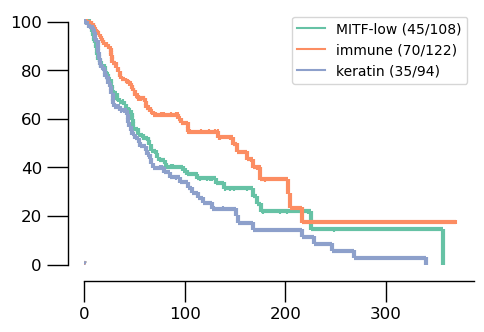

In [127]:
def plot_KM(df, group, ann = data_clinical_patient, size=(6, 3)): # df - DF with samples as index, group - column with cluster/class/subtype etc
    # get patients ID (first 12 symbols in sample ID)
    patients = []
    for string in df.index:
        patients.append(string[:12])
    df['PATIENT_ID'] = patients

    # list of patients with two samples
    double_samples = []
    for x in patients:
        if patients.count(x) > 1:
            double_samples.append(x)
    double_samples = list(set(double_samples))

    # get information about survival time from annotation
    surv = ann[['PATIENT_ID', 'OS_MONTHS', 'OS_STATUS']].set_index('PATIENT_ID')

    # remove patients with two samples (three), because I don't know how to analize them - samples belong to different classes
    df = df.set_index('PATIENT_ID')
    df = df.loc[df.index.drop(double_samples)]
    surv_uniq = surv.loc[surv.index.drop(double_samples)]

    # drop patients with NA
    surv_uniq = surv_uniq[surv_uniq.OS_MONTHS != '[Not Available]']
    df = pd.concat([df, surv_uniq], axis=1).dropna()

    # chage OS status to int
    df = df.replace(['1:DECEASED', '0:LIVING'],[1, 0])
    results = km.fit(df.OS_MONTHS, df.OS_STATUS, df[group])

    # Plot
    km.plot(results, cmap='Set2', width=size[0], height=size[1], title='', methodtype='custom')

plot_KM(cluster_top_1500, 'clusters_predicted')

The survival curves are similar to the curves in the article: "immune" class demonsrate better survival than other, and "keratin" - worse.   
To sum up, we were able to predict correctly clusters for 226 samples out of 329 (~68.7%).   
The result is so-so, but nevertheless we will try to repeat all the steps and cluster all 472 samples   

## 2. Repeat all steps for all samples

In [128]:
# select 1500 the most variable genes
top_1500_all = select_1500_genes(mrna_zcores)
top_1500_all.head(5)

,TCGA-3N-A9WB-06,TCGA-3N-A9WC-06,TCGA-3N-A9WD-06,TCGA-BF-A1PU-01,TCGA-BF-A1PV-01,TCGA-BF-A1PX-01,TCGA-BF-A1PZ-01,TCGA-BF-A1Q0-01,TCGA-BF-A3DJ-01,TCGA-BF-A3DL-01,...,TCGA-XV-AB01-06,TCGA-YD-A89C-06,TCGA-YD-A9TA-06,TCGA-YD-A9TB-06,TCGA-YG-AA3N-01,TCGA-YG-AA3O-06,TCGA-YG-AA3P-06,TCGA-Z2-A8RT-06,TCGA-Z2-AA3S-06,TCGA-Z2-AA3V-06
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,,
TMEM189-UBE2V1,-0.8187,-0.7122,-3.8273,1.3173,-1.1315,-3.8273,-1.0419,3.5824,-3.8273,0.9266,...,-3.8273,-3.8273,0.5078,-3.8273,1.4678,-3.8273,-3.8273,1.2392,-1.3505,-0.0449
CYorf15B,1.0308,0.8722,0.7954,-2.1528,-2.1528,0.2736,-2.1528,0.0463,-2.1528,-2.1528,...,-1.6555,-2.1528,1.5348,-2.1528,-0.3105,0.9675,-1.9076,-2.1528,-0.9057,-2.1528
CYorf15B,0.6868,0.7617,0.4533,-2.2316,-2.2316,0.5641,-2.2316,0.2353,-2.2316,-2.2316,...,-2.2316,-2.2316,1.3182,-2.2316,0.3082,0.9962,-2.2316,-2.2316,-0.8697,-2.2316
TTTY15,0.3841,0.8337,0.2062,-2.1327,-2.1327,0.5900,-2.1327,-0.7273,-2.1327,-2.1327,...,-2.1327,-2.1327,1.3886,-2.1327,0.3684,0.7812,-1.8933,-2.1327,1.4473,-2.1327
CSAG2,-2.9879,0.3141,-2.6129,-2.9879,-2.9879,-2.9879,-0.2063,0.9064,-2.6399,-2.9879,...,-2.9879,-1.3396,-0.5020,-2.2328,-1.2007,-2.9879,-2.9879,-0.8771,-0.0097,-2.9879


"Old" 1500 genes and "new" 1500 genes are not the same:

In [129]:
len(set(list(top_1500.index) + list(top_1500_all.index)))

1767

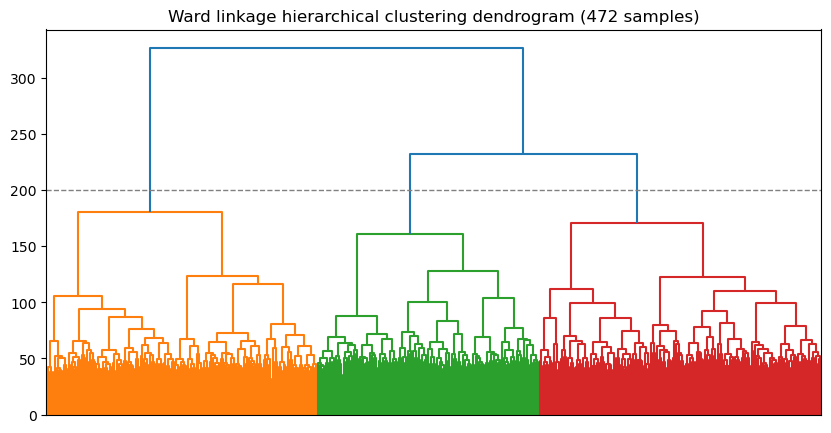

In [130]:
# plot dendrogram
plot_dendrogram(top_1500_all, title='Ward linkage hierarchical clustering dendrogram (472 samples)')

In [131]:
# clustering
X = np.array(top_1500_all.T)
clustering = AgglomerativeClustering(linkage='ward', n_clusters=3)
labels = list(clustering.fit(X).labels_)

# write results
cluster_top_1500_all = top_1500_all.T
cluster_top_1500_all.insert(0, 'labels', labels)

# look at the numbers of samples in each cluster
labels.count(0), labels.count(1), labels.count(2)

(165, 172, 135)

In [132]:
# Mann-Whitney U test
group1, group2, group3 = Mann_Whitney_test(cluster_top_1500_all, top_1500_all.index)

group1_genes_all = get_genes_table(group1)
group2_genes_all = get_genes_table(group2)
group3_genes_all = get_genes_table(group3)

Groups are the same: 1 - 'immune', 2 - 'MITF-low', 3 - 'keratin'

In [133]:
# add cluster's names
cluster_top_1500_all.labels = cluster_top_1500_all.labels.replace({0: 'immune', 1:'MITF-low', 2:'keratin'})

# add information about clusters from the reference article
cluster_top_1500_all = pd.concat([clustering_329.set_index('Name'), cluster_top_1500_all], axis=1)
cluster_top_1500_all = cluster_top_1500_all.rename(columns={'labels':'clusters_predicted', 
                                                    'RNASEQ-CLUSTER_CONSENHIER':'clusters_original'})

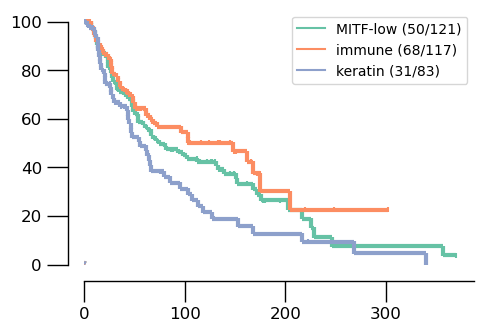

In [134]:
#  Kaplan-Meier curves
plot_KM(cluster_top_1500_all, 'clusters_predicted')

Now we have 210 out of 329 samples with same cluster as in reference article:

In [135]:
(cluster_top_1500_all.clusters_original == cluster_top_1500_all.clusters_predicted).value_counts()

False    262
True     210
Name: count, dtype: int64

Save main results:

In [136]:
group1_genes.to_csv('task1_significant_genes_description_immune_329_samples.csv')
group2_genes.to_csv('task1_significant_genes_description_MITF-low_329_samples.csv')
group3_genes.to_csv('task1_significant_genes_description_keratin_329_samples.csv')

group1_genes_all.to_csv('task1_significant_genes_description_immune_472_samples.csv')
group2_genes_all.to_csv('task1_significant_genes_description_MITF-low_472_samples.csv')
group3_genes_all.to_csv('task1_significant_genes_description_keratin_472_samples.csv')

clustering_472 = cluster_top_1500_all[['clusters_predicted']]
clustering_472.to_csv('task_1_clustering_472_samples.csv')

## 3. Classification    

Now we assume, that 329 samples were classified correctly. We can use information about them to classify rest 143 samples.   
There is interesting [study](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8942277/) compares different algorithms for classification patients based on gene-expression data. They used 50 datasets spanning diverse diseases and tissue types but focused primarily on cancer-related conditions. Generally, kernel- and ensemble-based algorithms outperformed other types of algorithms in this analyses. Based on this, we try two algorithms: logistic regression and random forest.   
Note: to be honest, we need to select important genes (feature selections), but let's try to do without it   
#### **3.1 Preparing dataset**

Split data into train and test; we use Z-score data, so we don't need use StandardScaler()

In [137]:
# DF "sample - cluster - genes" for 329 samples
to_train = pd.concat([clustering_329.set_index('Name').sort_index(), \
           mrna_zcores_329.drop(['Entrez_Gene_Id', 'MAD'], axis=1).set_index('Hugo_Symbol').T.sort_index()], axis=1)

# split data into train and test sets, 80% in train and 20% in test. 
# The "random_state" variable can be used to reproduce the split
train_data = to_train.sample(frac=0.8, random_state=1).sort_index()
test_data = to_train.drop(train_data.index)

train_y = train_data.pop('RNASEQ-CLUSTER_CONSENHIER')
test_y = test_data.pop('RNASEQ-CLUSTER_CONSENHIER')


In [138]:
# DF "sample - genes" for 143 "new" and 472 all samples
to_predict_143 = mrna_zcores.dropna().drop(['Entrez_Gene_Id', 'MAD'], axis=1).set_index('Hugo_Symbol').dropna().T.drop(to_train.index)
to_predict_472 = mrna_zcores.dropna().drop(['Entrez_Gene_Id', 'MAD'], axis=1).set_index('Hugo_Symbol').dropna().T

#### **3.2 Logistic Regression**

In [139]:
# train a logistic regression model
# we choose solver='newton-cg' for best score and time
lr = LogisticRegression(max_iter=1000, solver='newton-cg', multi_class='multinomial', C=0.1)
lr.fit(train_data.values, train_y)

LogisticRegression(C=0.1, max_iter=1000, multi_class='multinomial',
                   solver='newton-cg')

In [140]:
lr.score(test_data.values, test_y)

0.9242424242424242

Draw ROC curves "One-vs-Rest" for three groups (some code was taken from [documentation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)):

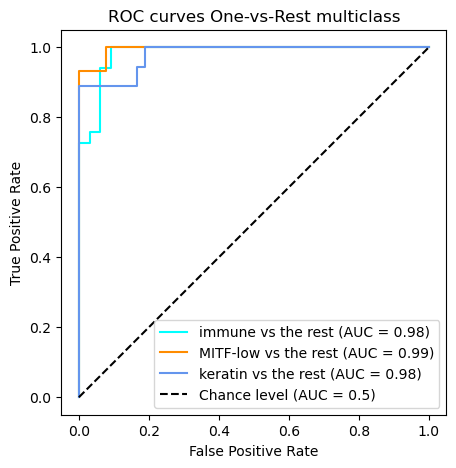

In [141]:
y_score = lr.fit(train_data, train_y).predict_proba(test_data)

def ROC_curves(y_score, train_y, test_y):
    label_binarizer = LabelBinarizer().fit(train_y)
    y_onehot_test = label_binarizer.transform(test_y)

    fig, ax = plt.subplots(figsize=(6, 5))

    colors = ["aqua", "darkorange", "cornflowerblue"]
    clusters = ['immune', 'MITF-low', 'keratin']
    for cluster, color in zip(clusters, colors):
        label_binarizer.transform([cluster])
        class_of_interest = cluster
        class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
        RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"{class_of_interest} vs the rest",
        color=color,
        ax = ax,
        plot_chance_level=(class_id == 2),
    )

    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curves One-vs-Rest multiclass")
    plt.legend()
    plt.show()

ROC_curves(y_score, train_y, test_y)

ROC curves looks good. Using lr-model, predict classes of 143 and 472 samples and count, how many classes of 329 samples are same as in reference article:

In [142]:
predicted_lr_143 = pd.DataFrame({'predicted': lr.predict(to_predict_143)}).set_index(to_predict_143.index).sort_index()
predicted_lr_472 = pd.DataFrame({'predicted': lr.predict(to_predict_472)}).set_index(to_predict_472.index).sort_index()

# concat with 329 samples classes from the reference article to compare results
predicted_lr_472 = pd.concat([clustering_329.set_index('Name').sort_index(), predicted_lr_472], axis=1)
predicted_lr_472 = predicted_lr_472.rename(columns={'predicted':'predicted_lr'})

324 samples out of 329 have same classes - it's much more better than using hierarchical clustering:

In [143]:
(predicted_lr_472['RNASEQ-CLUSTER_CONSENHIER'] == predicted_lr_472['predicted_lr']).value_counts()

True     324
False    148
Name: count, dtype: int64

Save results:

In [144]:
predicted_lr_472.to_csv('task1_lr_classify_472_samples.csv')
predicted_lr_143.to_csv('task1_lr_classify_143_samples.csv')

### **3.3 Random Forest**

In [145]:
# we already have test and train data, use RandomForestClassifier with default parameters
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_jobs = 10, n_estimators=100)
clf.fit(train_data, train_y)

RandomForestClassifier(n_jobs=10)

Score is lower, and ROC curvers look worse:

In [146]:
metrics.accuracy_score(test_y, clf.predict(test_data))

0.803030303030303

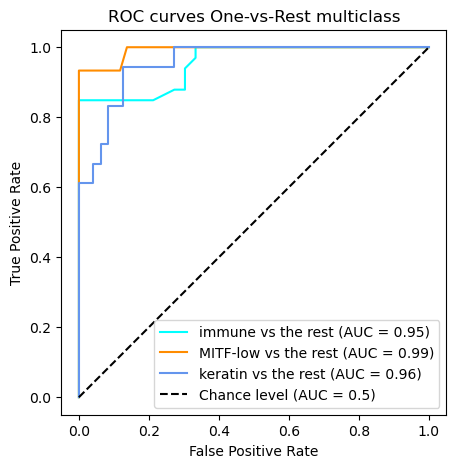

In [147]:
y_score = clf.fit(train_data, train_y).predict_proba(test_data)
ROC_curves(y_score, train_y, test_y)

In [148]:
predicted_clf_143 = pd.DataFrame({'predicted': clf.predict(to_predict_143)}).set_index(to_predict_143.index).sort_index()
predicted_clf_472 = pd.DataFrame({'predicted': clf.predict(to_predict_472)}).set_index(to_predict_472.index).sort_index()

# concat with 329 samples classes from the reference article to compare results
predicted_clf_472 = pd.concat([clustering_329.set_index('Name').sort_index(), predicted_clf_472], axis=1)
predicted_clf_472 = predicted_clf_472.rename(columns={'predicted':'predicted_clf'})

320 samples out of 329 have same classes:

In [149]:
(predicted_clf_472['RNASEQ-CLUSTER_CONSENHIER'] == predicted_clf_472['predicted_clf']).value_counts()

True     320
False    152
Name: count, dtype: int64

Save results:

In [150]:
predicted_clf_472.to_csv('task1_RF_classify_472_samples.csv')
predicted_clf_143.to_csv('taks1_RF_classify_143_samples.csv')

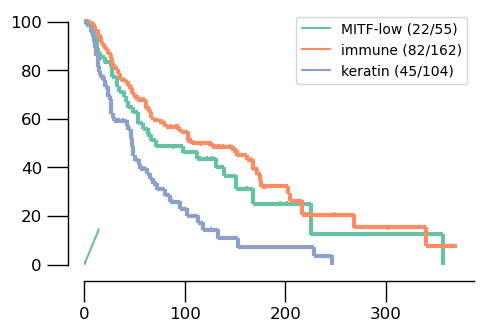

In [151]:
plot_KM(predicted_clf_472, 'predicted_clf')

*******************

# Task 2   
## Problem: 
there are [acticle](https://aacrjournals.org/clincancerres/article/16/13/3356/11021/Gene-Expression-Profiling-Based-Identification-of) that describes the procedure of genomic classification patients with stage IV melanoma. For gene expression analysis, they selected the 3,000 most variable RefSeq genes and run average linkage agglomerative hierarchical clustering with Pearson correlation distance. Four subgroups were identified by visual inspection of the hierarchical tree, called Pigmentation, Proliferative, Normal-like, High-immune response. The authors also validated the public independent datasets using using nearest centroid correlation. Centroids based on significant genes for each subtype were computed for each of the four classes found in train dataset. For each subtype, the 100 most significant genes were used, except for the normal-like group where all 77 significant genes were used, then computed the Pearson correlation coefficient of each sample in the validation data sets to each of the four centroids. Samples were classified based on the centroid displaying the highest correlation (correlation >0.1). 

We have centroid's coordinates from Supplementary Table of this article, so we can repeat described for independent datasets procedure for our 472 samples from previous task.   

We noticed, that data from the second experiment obtained using microchips, so absolute values of centroids cannot be transferred on NGS data from the first. But:   
- all data has been normalized   
- gene expression data in the first experiment are presented in Z-scale   
- the coordinates of the centroids seem to be also in Z-scale, although the procedure for processing raw data is not described in detail   
- we have no any other data in anyo ther formats.   
   
##### **1. Prepare data**

In [152]:
# download coordinates of centroids
genes_centroids = pd.read_table('genes_second_article.txt', delimiter=' ', header=None)
genes_centroids.columns = ['ProbeID', 'Probe', 'SYMBOL', 'Normal-like', 'Proliferative', \
                           'Pigmentation', 'High-immune responce']

Note, that authors saidabot 100 + 100 + 100 + 77 = 377 genes, but we have only 358 unique:

In [153]:
genes_centroids.drop_duplicates('SYMBOL')

,ProbeID,Probe,SYMBOL,Normal-like,Proliferative,Pigmentation,High-immune responce
0,5890445,ILMN_10232,FCHSD2,-0.179296,-0.233468,-0.348680,0.793797
1,4730750,ILMN_10292,TBC1D7,-0.471143,-0.661054,1.068625,-0.787198
...,...,...,...,...,...,...,...
363,5290537,ILMN_9994,KLF2,0.106593,-0.556403,-0.502153,1.124764
364,7570196,ILMN_9996,ICOS,-0.349296,-2.208939,0.568610,0.972219


In [154]:
# select expression data by genes from genes_centroids
df = mrna_zcores[mrna_zcores['Hugo_Symbol'].isin(genes_centroids['SYMBOL'])].drop(['Entrez_Gene_Id', 'MAD'], \
                                                                                  axis=1).set_index('Hugo_Symbol').sort_index()
df

,TCGA-3N-A9WB-06,TCGA-3N-A9WC-06,TCGA-3N-A9WD-06,TCGA-BF-A1PU-01,TCGA-BF-A1PV-01,TCGA-BF-A1PX-01,TCGA-BF-A1PZ-01,TCGA-BF-A1Q0-01,TCGA-BF-A3DJ-01,TCGA-BF-A3DL-01,...,TCGA-XV-AB01-06,TCGA-YD-A89C-06,TCGA-YD-A9TA-06,TCGA-YD-A9TB-06,TCGA-YG-AA3N-01,TCGA-YG-AA3O-06,TCGA-YG-AA3P-06,TCGA-Z2-A8RT-06,TCGA-Z2-AA3S-06,TCGA-Z2-AA3V-06
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,,
AADAT,0.9406,0.7642,-0.8577,0.2626,1.0801,-0.4675,-0.5017,0.0023,0.8158,-0.3659,...,-3.3189,1.5967,0.2884,0.5263,-2.2513,0.5282,-0.8271,0.1289,0.0298,-2.3755
ACSL5,-1.7575,1.8763,0.4186,-0.6434,-1.6541,0.6010,-1.2259,-0.2609,-0.2736,-1.0435,...,-0.7938,-1.7527,0.4196,0.1066,1.5573,-0.6454,-0.4836,0.4541,1.7642,0.6131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF366,-2.5676,0.1131,-0.3490,0.0017,-0.7287,0.8746,-1.0876,0.0858,-0.1353,0.4076,...,-0.0465,-2.2491,0.0405,0.9032,0.1061,-0.0949,-1.3438,0.2379,-0.1222,0.4353
ZNF789,0.4864,-0.2682,-0.2500,-0.2071,-0.3179,-1.5413,-0.4738,-1.0343,-0.7212,-1.2202,...,-0.1217,1.2698,1.5746,0.2134,-0.3399,1.0434,-0.0303,1.9519,0.5865,-2.2333


We have data only by 288 genes, so we will work with this

In [155]:
# prepare DF with centroids coordinates, with no additional information
centroids = genes_centroids.drop_duplicates('SYMBOL').drop(['ProbeID', 'Probe'], axis=1)
centroids = centroids.loc[centroids['SYMBOL'].isin(df.index)].set_index('SYMBOL').sort_index()
centroids

,Normal-like,Proliferative,Pigmentation,High-immune responce
SYMBOL,,,,
AADAT,-0.508825,1.341210,-0.282566,-0.387165
ACSL5,-0.023600,-1.426732,-0.174250,1.409539
...,...,...,...,...
ZNF366,-0.051903,-0.689680,-0.381466,1.138909
ZNF789,-0.211305,-0.302034,0.598127,-0.522931


##### **2. Calculate Pearson corralation for pairs "sample - centroid"**

In [156]:
def pearson_corr(col):
    corr = {}
    pvalues = {}
    for subtype in centroids.columns:
        if subtype not in corr.keys():
            corr[subtype] = pearsonr(centroids[subtype], col)[0]
            pvalues[subtype] = pearsonr(centroids[subtype], col)[1]
        else:
            corr[subtype].append(pearsonr(centroids[subtype], col)[0])
            pvalues[subtype].append(pearsonr(centroids[subtype], col)[1])
    return pd.DataFrame.from_dict(corr, orient='index'), pd.DataFrame.from_dict(pvalues, orient='index')
    
# get DF with corr coefficients and p-values
df_corr, df_pvalues = pd.DataFrame(), pd.DataFrame()
for col in df.columns:
    corr, pvalues = pearson_corr(df[col])
    df_corr = pd.concat([df_corr, corr], axis=1)
    df_pvalues = pd.concat([df_pvalues, pvalues], axis=1)

df_corr.columns = df.columns
df_pvalues.columns = df.columns

# if p-value < 0.05, set corr = 0
for i in range(df_pvalues.shape[0]):
    for j in range(df_pvalues.shape[1]):
        if df_pvalues.iloc[i, j] < 0.05:
            df_corr.iloc[i, j] = 0

In the [article](https://aacrjournals.org/clincancerres/article/16/13/3356/11021/XSLT_Related_Article_Replace_Href) they used correlation coefficient threshold > 0.1. Our correlations are too weak, and we select samples with correlation coefficient threshold > 0:

In [157]:
df_corr = df_corr.T
df_corr['max_corr'] = df_corr.apply(max, axis=1)
df_corr = df_corr.loc[df_corr.max_corr > 0]

Correlate the correlation coefficients with the subtypes:

In [158]:
def subtypes(row):
    d = row.to_dict()
    for key in d:
        if d[key] == max(d.values()):
            return key

df_corr['subtype'] = df_corr.drop('max_corr', axis=1).apply(subtypes, axis=1)
df_corr

,Normal-like,Proliferative,Pigmentation,High-immune responce,max_corr,subtype
TCGA-BF-A1PU-01,0.105626,0.060759,0.000000,0.0,0.105626,Normal-like
TCGA-BF-A1PV-01,0.037297,0.000000,0.000000,0.0,0.037297,Normal-like
...,...,...,...,...,...,...
TCGA-YG-AA3N-01,0.000000,0.000000,0.040824,0.0,0.040824,Pigmentation
TCGA-Z2-AA3V-06,0.019345,0.000000,-0.061693,0.0,0.019345,Normal-like


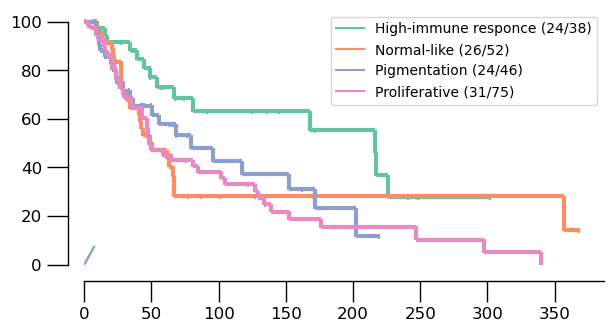

In [159]:
plot_KM(df_corr, 'subtype', size=(8, 3))

In [160]:
df_corr['subtype'].value_counts()

subtype
Proliferative           79
Normal-like             53
Pigmentation            47
High-immune responce    38
Name: count, dtype: int64

We split 217 samplesout of 472 into four groups.   
Save the results:

In [161]:
df_corr[['subtype']].to_csv('task2_correlation_217_samples.csv')

##### **3. Calculate distances from each sample to each centroid**
Now we try another way to split samples into four group. Let's calculate distances from each sample to each centroid, and for each sample choose the nearest centroid. As we are not sure, that expression data and centrois coordinates are in the same scale, we will use ```correlation``` distance metric:

In [162]:
# calculate distances
distances = pd.DataFrame.from_dict(distance.cdist(df.T, centroids.T, 'correlation'))
distances.columns = centroids.columns
distances.index = df.columns

# select the nearest centroid
def subtypes(row):
    d = row.to_dict()
    for key in d:
        if d[key] == min(d.values()):
            return key

distances['subtype'] = distances.apply(subtypes, axis=1)
distances

,Normal-like,Proliferative,Pigmentation,High-immune responce,subtype
TCGA-3N-A9WB-06,0.817230,0.841250,0.705656,1.666772,Pigmentation
TCGA-3N-A9WC-06,1.221977,1.251290,0.842360,0.736645,High-immune responce
...,...,...,...,...,...
TCGA-Z2-AA3S-06,1.334874,1.135139,0.595725,1.047548,Pigmentation
TCGA-Z2-AA3V-06,0.980655,1.232235,1.061693,0.748800,High-immune responce


In [163]:
distances['subtype'].value_counts()

subtype
Pigmentation            196
High-immune responce    138
Proliferative            74
Normal-like              64
Name: count, dtype: int64

##### **4. Kaplan-Meier curves**

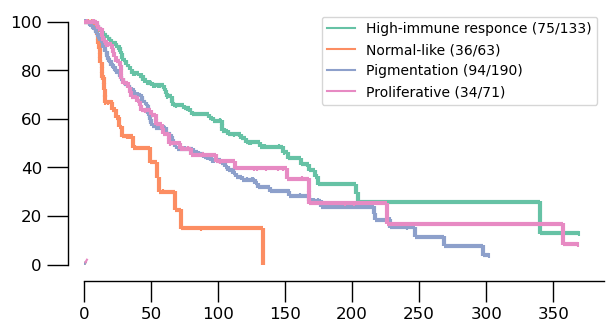

In [164]:
plot_KM(distances, 'subtype', size=(8, 3))

If we compare ROC curves from point 2 and 3 with curves from [article](https://aacrjournals.org/clincancerres/article/16/13/3356/11021/XSLT_Related_Article_Replace_Href), we see, that our classification do not reproduce influence of class on patient survival.   
It's not a surprise: this classification is far from ideal, and I would definitely not recommend using it for any prognosis

Save the reasults:

In [165]:
distances[['subtype']].to_csv('task2_distances_472_samples.csv')

##### **5. Combine all clusterization and classification results for 472 samples**

In [166]:
all_classifications_472 = pd.concat([cluster_top_1500_all[['clusters_original', 'clusters_predicted']], \
           predicted_lr_472[['predicted_lr']], predicted_clf_472[['predicted_clf']], \
            df_corr[['subtype']], distances[['subtype']]], axis=1)

all_classifications_472.columns = ['reference', 'AgglomerativeClustering', 'LogisticRegression', \
                                   'RandomForest', 'correlation_subtype', 'distances_subtype']

all_classifications_472

,reference,AgglomerativeClustering,LogisticRegression,RandomForest,correlation_subtype,distances_subtype
TCGA-BF-A1PU-01,keratin,keratin,keratin,keratin,Normal-like,Pigmentation
TCGA-BF-A1PV-01,keratin,keratin,keratin,keratin,Normal-like,Pigmentation
...,...,...,...,...,...,...
TCGA-Z2-AA3S-06,NaN,keratin,keratin,immune,NaN,Pigmentation
TCGA-Z2-AA3V-06,NaN,keratin,immune,immune,Normal-like,High-immune responce


In [167]:
all_classifications_472.to_csv('all_classifications_472_samples.csv')

***********************

# Task 3   

##### **1. To compare two types of classifications**,    
let's look again at classes description:    
   
***immune cluster***: genes overexpressed in this subclass were associated with immune cell subsets (T cells, B cells, and NK cells), immune signaling molecules, co-stimulatory and co-inhibitory immune checkpoint proteins, cytokines, chemokines, and corresponding receptors  
***keratin cluster***: characterized by high expression of genes associated with keratins, pigmentation, and epithelium, as well as genes associated with neuronal development or other organ-specific embryologic development    
***MITF-low cluster***: characterized by low expression of genes associated with pigmentation and epithelial expression, including several MITF target genes and genes involved in immunomodulation, adhesion, migration, and extra-cellular matrix. This cluster was significantly enriched with genes preferentially expressed within the nervous system and/or associated with neuronal development or other organ-specific embryologic development.    
    
***high-immune response subtype***: high expression of genes such as LCK, IFNGR1, HLA class I II antigen, CXCL12, and IL1R1, all involved in different immunologic processes (but also present also in the pigmentation and normal-like subtypes)   
***proliferative subtype***: displayed low expression of the same set of immune response genes as well as an elevated expression of cell cycle–associated genes such as E2F1, BUB1, and CCNA2, suggesting highly proliferative tumors   
***pigmentation subtype***: displayed a higher expression of genes (e.g., MITF, TYR, SILV, DCT, and EDNRB) involved in melanin synthesis and melanocyte differentiation as compared with the other subtypes   
***normal-like subtype*** expressed genes involved in epidermis and ectoderm development, such as KRT10 and KRT17, and also displayed high expression of KIT, FGFR3, and EGFR     

Judging by these descriptions, ***immune cluster*** and ***high-immune response subtype*** are practically the same genes with high expression. Both study show that "immune" group is statistically correlated with more favorable prognosis. ***Pigmentation subtype*** reminds ***keratin cluster***, but the last one includes genes associated with neuronal and other organ-specific embryologic development. Patients with keratin cluster exhibited worse outcome when compared with stage-matched samples assigned to the immune or MITF-low cluster, supporting the view that the keratin cluster represents, at least in part, a previously unappreciated but biologically distinct melanoma subtype with adverse prognosis. At the same time, the results of the second study regarding this pigmentation subtype are contradictory: this subgroup of patients had a good prognosis in one data set but a poor outcome in another (in test data set the proliferative group having worst prognosis). May be this set of genes are not enough for analyzing and predicting the condition of patients.   
Authors of the second article admit, that tumors with increased expression of immune response–related genes were present also in the pigmentation and normal-like subtypes (not only in high-immune response subtype).   
   
The cohort size in the first study is several times larger than in the second: 329 samles VS 57. But on the other hand, the authors of the second study used independent datasets for validation (although the results are not always reproducible).   

**Considering the above, I believe that the first classification more accurately selects significant genes; this classification better reflects the biology of tumors and divides patients into risk groups.**     

   
##### **2. What about this analysis?**    
I can say that the authors' results were reproduced very partially. Among the main reasons I will name:    
1. (the most important) Lack of experience. I'll work on it   
2. sometimes incomplete description of procedures in articles   
3. perhaps it would be worth repeating the procedures from the very beginning - from raw sequencing data   

Below I have provided notes and some thoughts on “how it should have been done”

***********************************

# Notes 
##### **What should be improve**  
1. We did not take into outliers analysis, and they necessarily influence the classification results    
2. In task 1 we choose top 1500 the most variable genes usind MAD. I think, there is much precise way   
3. We use Mann-Witney U test to compare three groups. It's not OK, obviously. The best way to use differential gene expression analysis, but this requires non-normalized data. It is possible to get them from raw alignment data (the link there is in Supplementary Materials)   
Another way - ANOVA with multiple test adjustment.  
4. To classify samples we use logistic regression and random forest algorithm, but with all genes in the dataset. Here we need to select significant genes, check for interactions between genes, in a word - make a normal feature selection. This also introduces bias into the results. Moreover, it is necessary to test another classification algorithms    
5. Task 2 requires much more attention: the described in the reference article procedure is failed in our work (correlation between samples and centroids). Maybe I misunderstand this algorithms, or maybe it is just not sutable for data described in the first article. The work in these centroid coordinates remains questionable - in which school are they given? It would be good to take the independent data analyzed in this article and see if the results can be replicated with them.   

******************************